# **Background**

p53 is a critical tumor suppressor protein, frequently mutated in over half of all human cancers. These mutations typically present as either missense point mutations, which alter protein function, or null mutations, resulting in complete loss of protein expression.

p53 governs a broad network of downstream responses, including cell cycle arrest, apoptosis, senescence, and DNA repair. In our previous studies, we observed that pharmacological modulators of p53 can exhibit synergistic effects when coadministered with certain cytotoxic agents. To identify and prioritize additional candidate modulators, we developed a knowledge graph centered on p53 related targets and interrogated it using SPARQL queries.

This project focuses on two major p53 regulated pathways, cell cycle arrest and apoptosis, selected for their relevance and the availability of robust experimental assays. Specifically, we assess **cell cycle** dynamics using flow cytometry and measure **apoptosis** through Annexin V and PI staining, also analyzed by flow cytometry. Alamar Blue assays are used in parallel to evaluate **cell viability** and potential drug synergy.

## Cell Cycle Arrest assay

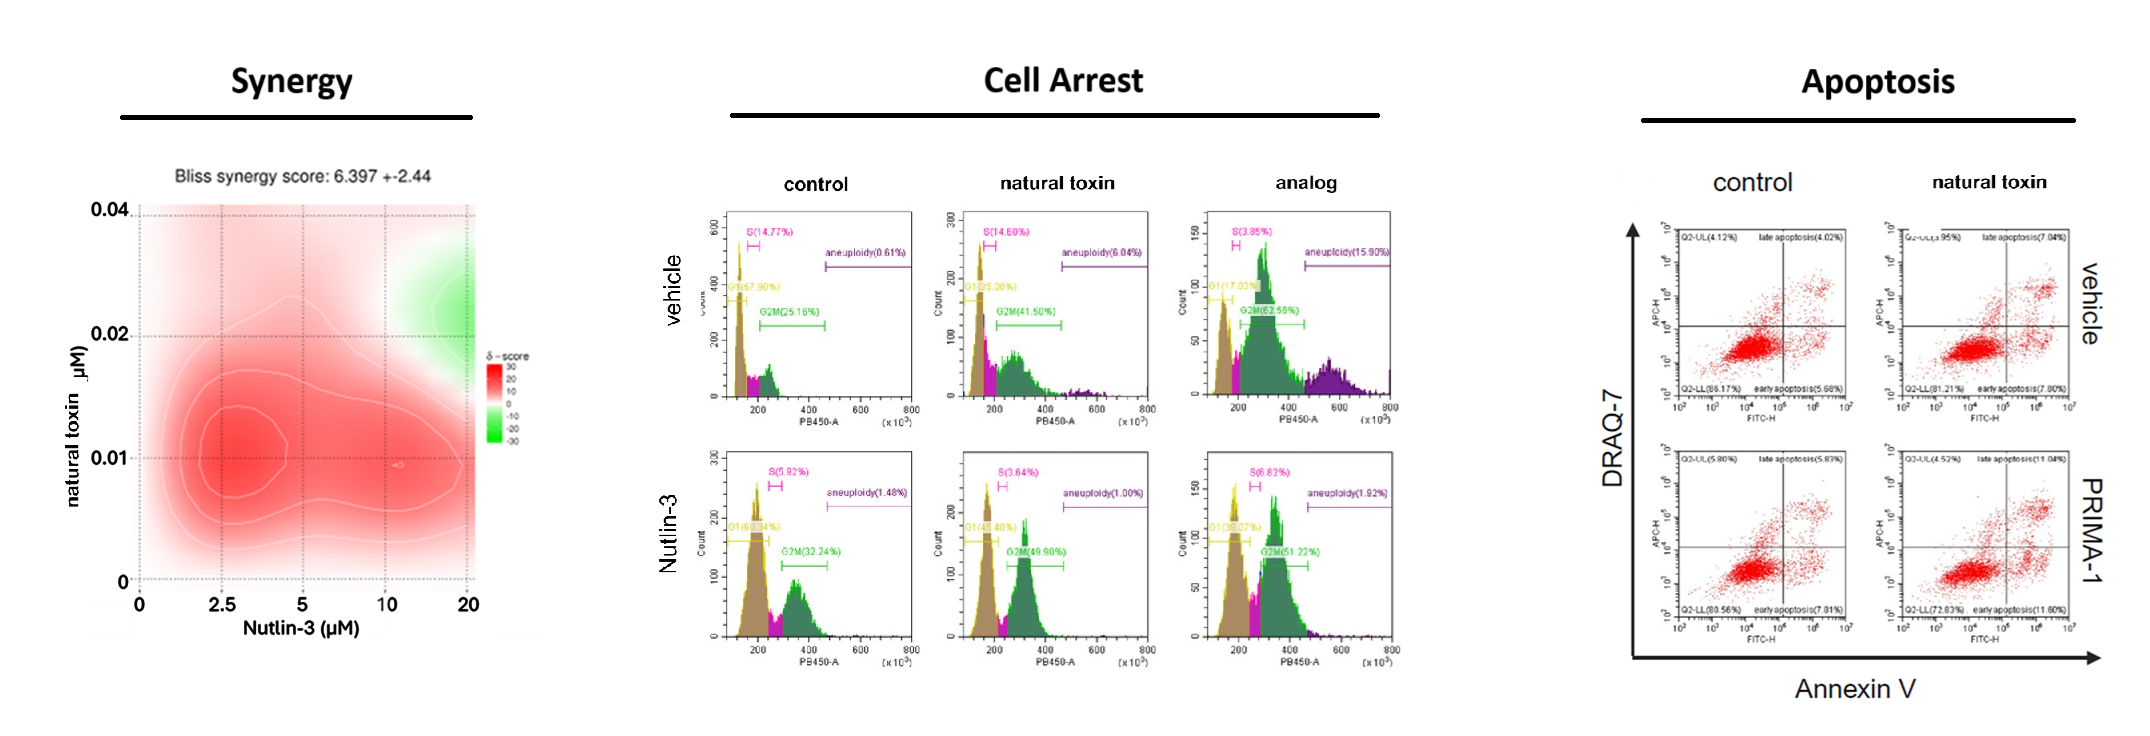

#P53 WildType

As a major tumor suppressor studied extensively in cancer biology, wild-type p53 is tightly regulated by upstream negative regulators such as MDM2. Small molecule inhibitors that disrupt these regulatory interactions can stabilize and activate p53, leading to enhanced transcriptional activation of downstream effectors involved in cell cycle arrest and apoptosis.

In [ ]:
!pip install rdflib

In [ ]:
from rdflib import Graph, Namespace, RDF
import pandas as pd

# Load ontology
g = Graph()
g.parse("TP53_onto.ttl", format="turtle")

# Define namespace
ns = Namespace("http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/")

In [ ]:
# SPARQL query
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?cellLine ?cancerType ?ATCC_label

WHERE {
  ?cellLine rdf:type ?cancerType .
  ?cellLine :harbours_variant :TP53_WildType .
  ?cancerType rdfs:subClassOf :cancer .

  OPTIONAL { ?cellLine :hasATCCID ?ATCC_label . }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "CellLine": row.cellLine.split("/")[-1],
        "CancerType": row.cancerType.split("/")[-1],
        "ATCC_label": row.ATCC_label,
        "P53Mutation": "WildType"
    })

# Convert to DataFrame
df_WT_Cell = pd.DataFrame(rows)

In [ ]:
df_WT_Cell

,CellLine,CancerType,ATCC_label,P53Mutation
0,U-2_OS,bone,HTB-96,WildType
1,MDA-MB-361,breast,HTB-27,WildType
2,LS174T,colon,CL-188,WildType
3,SW48,colon,CCL-231,WildType
4,A549,lung,CRM-CCL-185,WildType
5,NCI-H1882,lung,None,WildType
6,SW1990,pancreas,CRL-2172,WildType
7,AGS,stomach,CRL-1739,WildType


In [ ]:
# SPARQL query
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?drug ?label ?comment ?mechanism ?action ?target
WHERE {
  ?drug a :ChemicalModulator .

  OPTIONAL { ?drug rdfs:comment ?comment . }
  OPTIONAL { ?drug :hasCASNo ?label . }


  {
    ?drug :stabilizes_protein :P53_wildtype_protein .
    BIND("stabilizes_protein" AS ?action)
    BIND(:P53_wildtype_protein AS ?target)
  }
  UNION
  {
    ?drug :activates_protein :P53_wildtype_protein .
    BIND("activates_protein" AS ?action)
    BIND(:P53_wildtype_protein AS ?target)
  }
  UNION
  {
    ?drug :inhibits_protein :MDM2_protein .
    BIND("inhibits_protein" AS ?action)
    BIND(:MDM2_protein AS ?target)
  }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "treatment": row.drug.split("/")[-1],
        "target": row.target.split("/")[-1],
        "action": row.action.split("/")[-1],
        "comment": row.comment,
        "label": row.label,
        "P53Mutation": "WildType"
    })

# Convert to DataFrame
df_WT_treatment = pd.DataFrame(rows)

In [ ]:
df_WT_treatment

,treatment,target,action,comment,label,P53Mutation
0,JNJ-26854165,MDM2_protein,inhibits_protein,None,None,WildType
1,Nutlin_3,MDM2_protein,inhibits_protein,None,None,WildType
2,tenovin-6,P53_wildtype_protein,activates_protein,None,None,WildType


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

/tmp/ipython-input-166-705706493.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


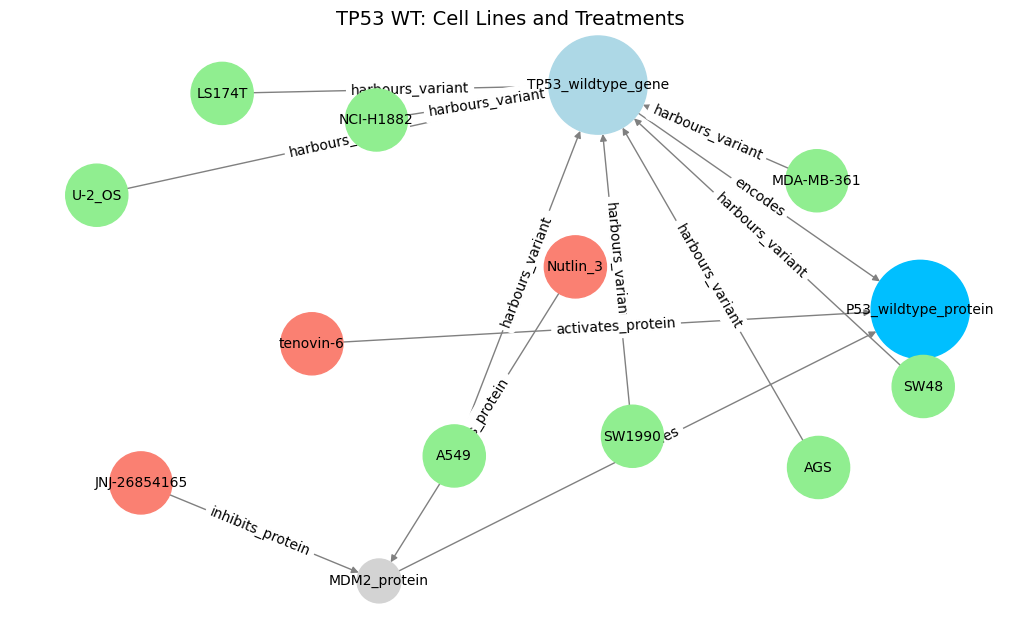

In [ ]:

# --- Build the graph ---
G = nx.DiGraph()

# Add mutation and protein nodes
G.add_node("TP53_wildtype_gene", label="TP53_wildtype_gene", color="lightblue", size=5000)
G.add_node("P53_wildtype_protein", label="P53_wildtype_protein", color="deepskyblue", size=5000)
G.add_edge("TP53_wildtype_gene", "P53_wildtype_protein", label="encodes")
G.add_edge("MDM2_protein", "P53_wildtype_protein", label="degrades")

# Add cell lines
for _, row in df_WT_Cell.iterrows():
    G.add_node(row["CellLine"], label=row["CellLine"], color="lightgreen", size=2000)
    G.add_edge(row["CellLine"], "TP53_wildtype_gene", label="harbours_variant")

# Add treatments
for _, row in df_WT_treatment.iterrows():
    G.add_node(row["treatment"], label=row["treatment"], color="salmon", size=2000)
    G.add_edge(row["treatment"], row["target"], label=row["action"])

for n in G.nodes:
    G.nodes[n].setdefault('color', 'lightgray')
    G.nodes[n].setdefault('label', n)
    G.nodes[n].setdefault('size', 1000)

# --- Step 3: Visualize ---
pos = nx.spring_layout(G, k=1.5, seed=42)
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_sizes = [G.nodes[n]['size'] for n in G.nodes]
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(10, 6))
nx.draw(G, pos,
        labels=labels,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        font_size=10,
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("TP53 WT: Cell Lines and Treatments", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

# P53 Mutations

Mapping of p53 mutations has shown that 6 to 8 hotspot residues account for a large proportion of point mutations observed in cancer patients. Among these, mutations at R175, R220, R248, and R273 are the most frequently reported. Some of these alterations interfere with the DNA-binding function of p53, resulting in loss of tumor suppressor activity or even gain-of-function effects that contribute to oncogenesis. Others lead to misfolding and protein aggregation, a phenomenon described as prion-like behavior. To address these functional impairments, various chemical modulators have been explored to partially restore p53 activity and reactivate its tumor-suppressive functions.

##R175H conformation mutation

Treatments targeting the R175H mutant often act by covalently binding to groups on mutant p53 proteins, promoting a partial restoration of the wild-type conformation. However, these mechanisms are typically not mutation-specific and may apply to a broader range of p53 missense mutations that retain modifiable cysteine residues.

In [ ]:
# SPARQL query
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?cellLine ?cancerType ?ATCC_label

WHERE {
  ?cellLine rdf:type ?cancerType .
  ?cellLine :harbours_variant :TP53_R175H_gene .
  ?cancerType rdfs:subClassOf :cancer .

  OPTIONAL { ?cellLine :hasATCCID ?ATCC_label . }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "CellLine": row.cellLine.split("/")[-1],
        "CancerType": row.cancerType.split("/")[-1],
        "ATCC_label": row.ATCC_label,
        "P53Mutation": "P53_R175H"
    })

# Convert to DataFrame
df_R175H_Cell = pd.DataFrame(rows)

In [ ]:
df_R175H_Cell

,CellLine,CancerType,ATCC_label,P53Mutation
0,AU565,breast,CRL-2351,P53_R175H
1,SK-BR-3,breast,HTB-30,P53_R175H
2,LS123,colon,CCL-255,P53_R175H


In [ ]:
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?drug ?label ?comment ?mechanism ?action ?target
WHERE {
  ?drug a :ChemicalModulator .

  OPTIONAL { ?drug rdfs:comment ?comment . }
  OPTIONAL { ?drug :hasCASNo ?label . }


  {
    ?drug :reactivates :P53_R175H_protein .
    BIND("reactivates" AS ?action)
    BIND(:P53_R175H_protein AS ?target)
  }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "treatment": row.drug.split("/")[-1],
        "target": row.target.split("/")[-1],
        "comment": row.comment,
        "label": row.label,
        "P53Mutation": "R175H"
    })

# Convert to DataFrame
df_R175H_treatment = pd.DataFrame(rows)

In [ ]:
df_R175H_treatment

,treatment,target,comment,label,P53Mutation
0,APR246,P53_R175H_protein,None,None,R175H
1,COTI2,P53_R175H_protein,None,None,R175H
2,MIRA-1,P53_R175H_protein,None,72835-26-8,R175H
3,NSC319726,P53_R175H_protein,https://doi.org/10.1016/j.ccr.2012.03.042,71555-25-4,R175H
4,NSC328784,P53_R175H_protein,10.1124/mol.116.107409,None,R175H
5,RITA,P53_R175H_protein,10.1074/jbc.M501664200,213261-59-7,R175H


/tmp/ipython-input-164-4048997370.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


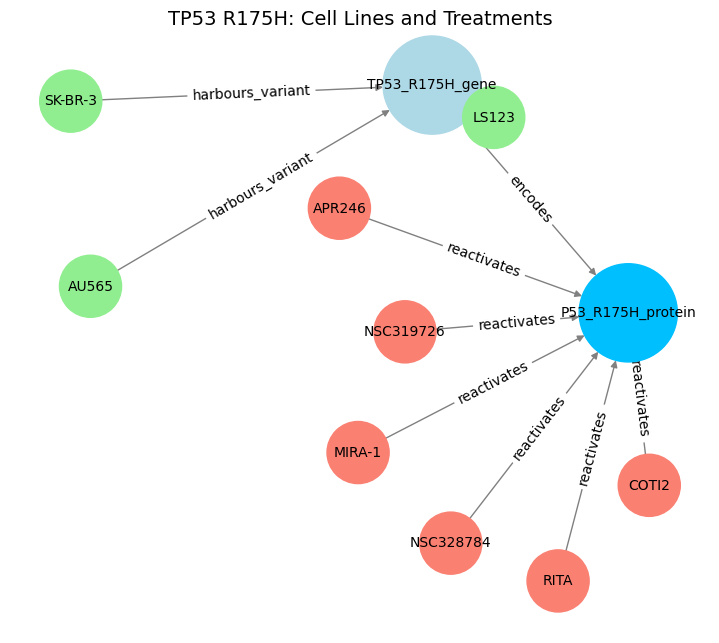

In [ ]:
# --- Build the graph ---
G = nx.DiGraph()

# Add mutation and protein nodes
G.add_node("TP53_R175H_gene", label="TP53_R175H_gene", color="lightblue", size=5000)
G.add_node("P53_R175H_protein", label="P53_R175H_protein", color="deepskyblue", size=5000)
G.add_edge("TP53_R175H_gene", "P53_R175H_protein", label="encodes")

# Add cell lines
for _, row in df_R175H_Cell.iterrows():
    G.add_node(row["CellLine"], label=row["CellLine"], color="lightgreen", size=2000)
    G.add_edge(row["CellLine"], "TP53_R175H_gene", label="harbours_variant")

# Add treatments
for _, row in df_R175H_treatment.iterrows():
    G.add_node(row["treatment"], label=row["treatment"], color="salmon", size=2000)
    G.add_edge(row["treatment"], row["target"], label="reactivates")

# --- Step 3: Visualize ---
pos = nx.spring_layout(G, k=0.8, seed=42)
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_sizes = [G.nodes[n]['size'] for n in G.nodes]
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(7, 6))
nx.draw(G, pos,
        labels=labels,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        font_size=10,
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("TP53 R175H: Cell Lines and Treatments", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

## R273 DNA binding mutation

The R273H mutation disrupts the DNA-binding interface of p53 without altering its overall structure. Treatments targeting this mutation typically aim to restore transcriptional activity by modulating protein interactions or stabilizing the DNA-contact domain, though fully restoring wild-type function remains a challenge.

###R273H

In [ ]:
# SPARQL query
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?cellLine ?cancerType ?ATCC_label

WHERE {
  ?cellLine rdf:type ?cancerType .
  ?cellLine :harbours_variant :TP53_R273H_gene .
  ?cancerType rdfs:subClassOf :cancer .

  OPTIONAL { ?cellLine :hasATCCID ?ATCC_label . }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "CellLine": row.cellLine.split("/")[-1],
        "CancerType": row.cancerType.split("/")[-1],
        "ATCC_label": row.ATCC_label,
        "P53Mutation": "P53_R273H"
    })

# Convert to DataFrame
df_R273H_Cell = pd.DataFrame(rows)

In [ ]:
df_R273H_Cell

,CellLine,CancerType,ATCC_label,P53Mutation
0,MDA-MB-468,breast,HTB-132,P53_R273H
1,WiDr,colon,CCL-218,P53_R273H
2,NCI-H1975,lung,CRL-5908,P53_R273H
3,PANC_1,pancreas,CRL-1469,P53_R273H


In [ ]:
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?drug ?label ?comment ?mechanism ?action ?target
WHERE {
  ?drug a :ChemicalModulator .

  OPTIONAL { ?drug rdfs:comment ?comment . }
  OPTIONAL { ?drug :hasCASNo ?label . }


  {
    ?drug :reactivates :P53_R273H_protein .
    BIND("reactivates" AS ?action)
    BIND(:P53_R273H_protein AS ?target)
  }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "treatment": row.drug.split("/")[-1],
        "target": row.target.split("/")[-1],
        "comment": row.comment,
        "label": row.label,
        "P53Mutation": "R273H"
    })

# Convert to DataFrame
df_R273H_treatment = pd.DataFrame(rows)

In [ ]:
df_R273H_treatment

,treatment,target,comment,label,P53Mutation
0,APR246,P53_R273H_protein,None,None,R273H
1,COTI2,P53_R273H_protein,None,None,R273H
2,MIRA-1,P53_R273H_protein,None,72835-26-8,R273H
3,RITA,P53_R273H_protein,10.1074/jbc.M501664200,213261-59-7,R273H


/tmp/ipython-input-163-1546424008.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


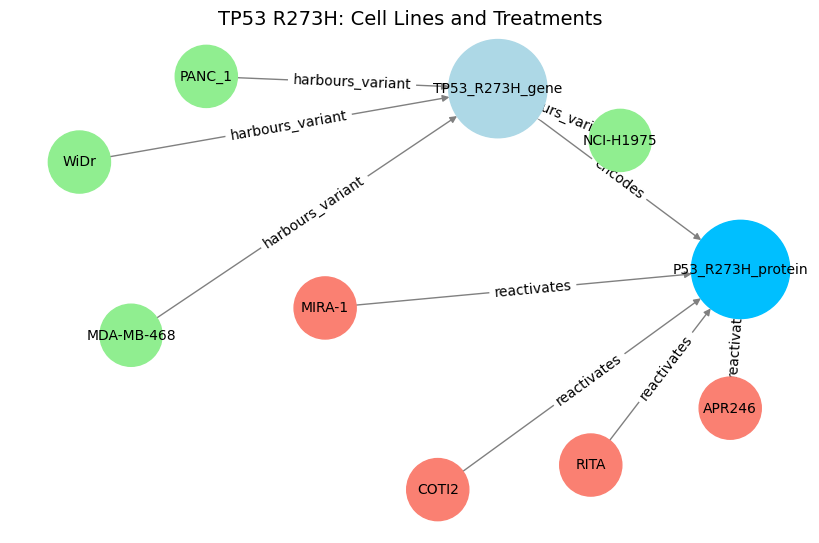

In [ ]:
# --- Build the graph ---
G = nx.DiGraph()

# Add mutation and protein nodes
G.add_node("TP53_R273H_gene", label="TP53_R273H_gene", color="lightblue", size=5000)
G.add_node("P53_R273H_protein", label="P53_R273H_protein", color="deepskyblue", size=5000)
G.add_edge("TP53_R273H_gene", "P53_R273H_protein", label="encodes")

# Add cell lines
for _, row in df_R273H_Cell.iterrows():
    G.add_node(row["CellLine"], label=row["CellLine"], color="lightgreen", size=2000)
    G.add_edge(row["CellLine"], "TP53_R273H_gene", label="harbours_variant")

# Add treatments
for _, row in df_R273H_treatment.iterrows():
    G.add_node(row["treatment"], label=row["treatment"], color="salmon", size=2000)
    G.add_edge(row["treatment"], row["target"], label="reactivates")


# --- Step 3: Visualize ---
pos = nx.spring_layout(G, k=1.5, seed=42)
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_sizes = [G.nodes[n]['size'] for n in G.nodes]
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(8, 5))
nx.draw(G, pos,
        labels=labels,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        font_size=10,
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("TP53 R273H: Cell Lines and Treatments", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

###R273C

```
# This is formatted as code
```



In [ ]:
# SPARQL query
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?cellLine ?cancerType ?ATCC_label

WHERE {
  ?cellLine rdf:type ?cancerType .
  ?cellLine :harbours_variant :TP53_R273C_gene .
  ?cancerType rdfs:subClassOf :cancer .

  OPTIONAL { ?cellLine :hasATCCID ?ATCC_label . }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "CellLine": row.cellLine.split("/")[-1],
        "CancerType": row.cancerType.split("/")[-1],
        "ATCC_label": row.ATCC_label,
        "P53Mutation": "P53_R273C"
    })

# Convert to DataFrame
df_R273C_Cell = pd.DataFrame(rows)

In [ ]:
df_R273C_Cell

,CellLine,CancerType,ATCC_label,P53Mutation
0,NCI-H1048,lung,CRL-5853,P53_R273C


In [ ]:
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?drug ?label ?comment ?mechanism ?action ?target
WHERE {
  ?drug a :ChemicalModulator .

  OPTIONAL { ?drug rdfs:comment ?comment . }
  OPTIONAL { ?drug :hasCASNo ?label . }


  {
    ?drug :reactivates :P53_R273C_protein .
    BIND("reactivates" AS ?action)
    BIND(:P53_R273C_protein AS ?target)
  }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "treatment": row.drug.split("/")[-1],
        "target": row.target.split("/")[-1],
        "comment": row.comment,
        "label": row.label,
        "P53Mutation": "R273C"
    })

# Convert to DataFrame
df_R273C_treatment = pd.DataFrame(rows)

In [ ]:
df_R273C_treatment

,treatment,target,comment,label,P53Mutation
0,COTI2,P53_R273C_protein,None,None,R273C


/tmp/ipython-input-162-1861354529.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


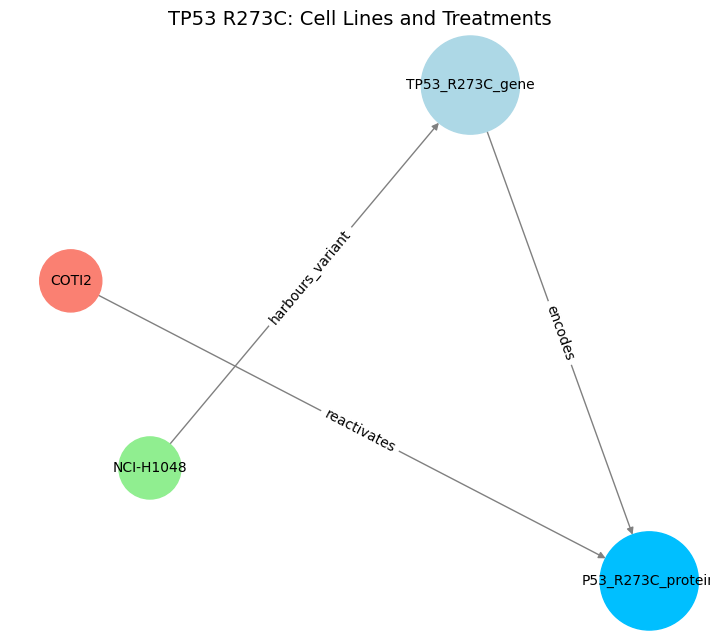

In [ ]:
# --- Build the graph ---
G = nx.DiGraph()

# Add mutation and protein nodes
G.add_node("TP53_R273C_gene", label="TP53_R273C_gene", color="lightblue", size=5000)
G.add_node("P53_R273C_protein", label="P53_R273C_protein", color="deepskyblue", size=5000)
G.add_edge("TP53_R273C_gene", "P53_R273C_protein", label="encodes")

# Add cell lines
for _, row in df_R273C_Cell.iterrows():
    G.add_node(row["CellLine"], label=row["CellLine"], color="lightgreen", size=2000)
    G.add_edge(row["CellLine"], "TP53_R273C_gene", label="harbours_variant")

# Add treatments
for _, row in df_R273C_treatment.iterrows():
    G.add_node(row["treatment"], label=row["treatment"], color="salmon", size=2000)
    G.add_edge(row["treatment"], row["target"], label="reactivates")


# --- Step 3: Visualize ---
pos = nx.spring_layout(G, k=1, seed=42)
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_sizes = [G.nodes[n]['size'] for n in G.nodes]
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(7, 6))
nx.draw(G, pos,
        labels=labels,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        font_size=10,
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("TP53 R273C: Cell Lines and Treatments", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

##R248 DNA binding mutation

The R248Q/W mutations, like R273, are classified as contact mutations, maintaining overall protein structure but losing transcriptional activity. Treatments targeting R248 mutations aim to restore function through allosteric reactivation, stabilization, or modulation of regulatory networks. And mutation-specific reactivators for R248 remain an area of active research.

###R248W

In [ ]:
# SPARQL query
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?cellLine ?cancerType ?ATCC_label

WHERE {
  ?cellLine rdf:type ?cancerType .
  ?cellLine :harbours_variant :TP53_R248W_gene .
  ?cancerType rdfs:subClassOf :cancer .

  OPTIONAL { ?cellLine :hasATCCID ?ATCC_label . }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "CellLine": row.cellLine.split("/")[-1],
        "CancerType": row.cancerType.split("/")[-1],
        "ATCC_label": row.ATCC_label,
        "P53Mutation": "P53_R248W"
    })

# Convert to DataFrame
df_R248W_Cell = pd.DataFrame(rows)

In [ ]:
df_R248W_Cell

,CellLine,CancerType,ATCC_label,P53Mutation
0,COLO_320DM,colon,CCL-220,P53_R248W
1,NCI-H1770,lung,CRL-5893,P53_R248W
2,MIA-PaCa-2,pancreas,CRL-1420,P53_R248W


In [ ]:
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?drug ?label ?comment ?mechanism ?action ?target
WHERE {
  ?drug a :ChemicalModulator .

  OPTIONAL { ?drug rdfs:comment ?comment . }
  OPTIONAL { ?drug :hasCASNo ?label . }


  {
    ?drug :reactivates :P53_R248W_protein .
    BIND("reactivates" AS ?action)
    BIND(:P53_R248W_protein AS ?target)
  }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "treatment": row.drug.split("/")[-1],
        "target": row.target.split("/")[-1],
        "comment": row.comment,
        "label": row.label,
        "P53Mutation": "R248W"
    })

# Convert to DataFrame
df_R248W_treatment = pd.DataFrame(rows)

In [ ]:
df_R248W_treatment

,treatment,target,comment,label,P53Mutation
0,ADH-6,P53_R248W_protein,https://doi.org/10.1038/s41467-021-23985-1,2227429-65-2,R248W
1,MIRA-1,P53_R248W_protein,None,72835-26-8,R248W
2,RITA,P53_R248W_protein,10.1074/jbc.M501664200,213261-59-7,R248W


/tmp/ipython-input-156-4156120658.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


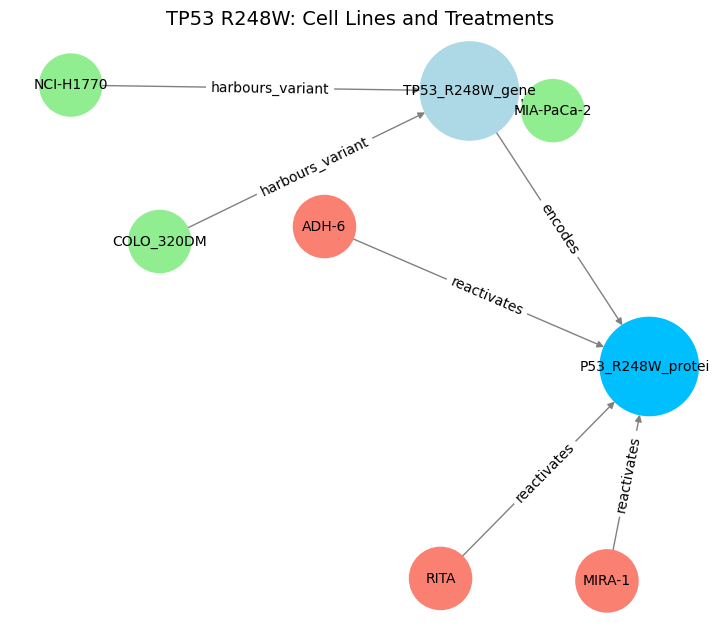

In [ ]:
# --- Build the graph ---
G = nx.DiGraph()

# Add mutation and protein nodes
G.add_node("TP53_R248W_gene", label="TP53_R248W_gene", color="lightblue", size=5000)
G.add_node("P53_R248W_protein", label="P53_R248W_protein", color="deepskyblue", size=5000)
G.add_edge("TP53_R248W_gene", "P53_R248W_protein", label="encodes")

# Add cell lines
for _, row in df_R248W_Cell.iterrows():
    G.add_node(row["CellLine"], label=row["CellLine"], color="lightgreen", size=2000)
    G.add_edge(row["CellLine"], "TP53_R248W_gene", label="harbours_variant")

# Add treatments
for _, row in df_R248W_treatment.iterrows():
    G.add_node(row["treatment"], label=row["treatment"], color="salmon", size=2000)
    G.add_edge(row["treatment"], row["target"], label="reactivates")


# --- Step 3: Visualize ---
pos = nx.spring_layout(G, k=1, seed=42)
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_sizes = [G.nodes[n]['size'] for n in G.nodes]
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(7, 6))
nx.draw(G, pos,
        labels=labels,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        font_size=10,
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("TP53 R248W: Cell Lines and Treatments", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

###R28Q

In [ ]:
# SPARQL query
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?cellLine ?cancerType ?ATCC_label

WHERE {
  ?cellLine rdf:type ?cancerType .
  ?cellLine :harbours_variant :TP53_R248Q_gene .
  ?cancerType rdfs:subClassOf :cancer .

  OPTIONAL { ?cellLine :hasATCCID ?ATCC_label . }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "CellLine": row.cellLine.split("/")[-1],
        "CancerType": row.cancerType.split("/")[-1],
        "ATCC_label": row.ATCC_label,
        "P53Mutation": "P53_R248Q"
    })

# Convert to DataFrame
df_R248Q_Cell = pd.DataFrame(rows)

In [ ]:
df_R248Q_Cell

,CellLine,CancerType,ATCC_label,P53Mutation
0,HCC70,breast,CRL-2315,P53_R248Q
1,NCI-H719,lung,CRL-5837,P53_R248Q


In [ ]:
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?drug ?label ?comment ?mechanism ?action ?target
WHERE {
  ?drug a :ChemicalModulator .

  OPTIONAL { ?drug rdfs:comment ?comment . }
  OPTIONAL { ?drug :hasCASNo ?label . }


  {
    ?drug :reactivates :P53_R248Q_protein .
    BIND("reactivates" AS ?action)
    BIND(:P53_R248Q_protein AS ?target)
  }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "treatment": row.drug.split("/")[-1],
        "target": row.target.split("/")[-1],
        "comment": row.comment,
        "label": row.label,
        "P53Mutation": "R248Q"
    })

# Convert to DataFrame
df_R248Q_treatment = pd.DataFrame(rows)

In [ ]:
df_R248Q_treatment

,treatment,target,comment,label,P53Mutation
0,MIRA-1,P53_R248Q_protein,None,72835-26-8,R248Q


/tmp/ipython-input-153-2779439176.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


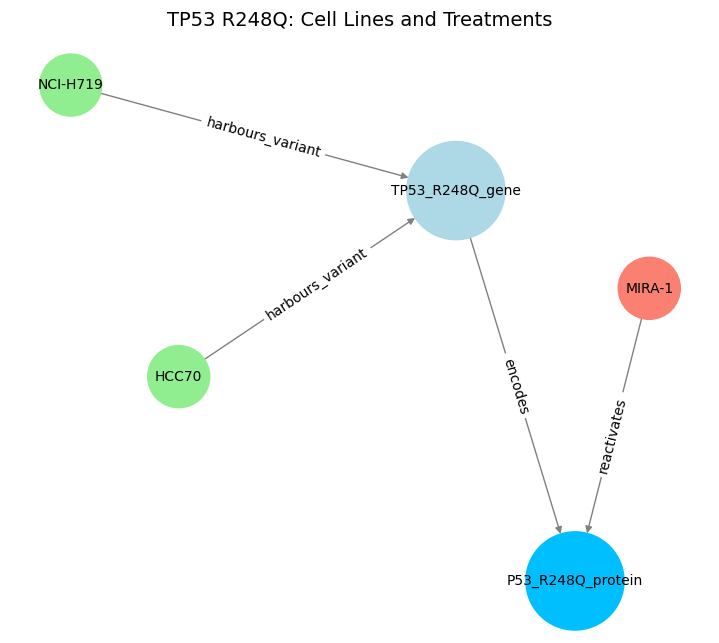

In [ ]:
# --- Build the graph ---
G = nx.DiGraph()

# Add mutation and protein nodes
G.add_node("TP53_R248Q_gene", label="TP53_R248Q_gene", color="lightblue", size=5000)
G.add_node("P53_R248Q_protein", label="P53_R248Q_protein", color="deepskyblue", size=5000)
G.add_edge("TP53_R248Q_gene", "P53_R248Q_protein", label="encodes")

# Add cell lines
for _, row in df_R248Q_Cell.iterrows():
    G.add_node(row["CellLine"], label=row["CellLine"], color="lightgreen", size=2000)
    G.add_edge(row["CellLine"], "TP53_R248Q_gene", label="harbours_variant")

# Add treatments
for _, row in df_R248Q_treatment.iterrows():
    G.add_node(row["treatment"], label=row["treatment"], color="salmon", size=2000)
    G.add_edge(row["treatment"], row["target"], label="reactivates")


# --- Step 3: Visualize ---
pos = nx.spring_layout(G, k=1.5, seed=42)
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_sizes = [G.nodes[n]['size'] for n in G.nodes]
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(7, 6))
nx.draw(G, pos,
        labels=labels,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        font_size=10,
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("TP53 R248Q: Cell Lines and Treatments", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

##Y220C conformation mutation

Y220C, like R175H, is a conformational (structural) mutation in p53. It replaces a tyrosine with a cysteine, creating a surface crevice that destabilizes the protein’s structure. This newly formed pocket presents a unique opportunity for structure-based drug design. Small molecules that bind and stabilize this crevice can restore partial tumor suppressor function. Several of these compounds are currently in preclinical development or early-phase clinical trials, representing a promising mutation-specific therapeutic strategy.

In [ ]:
# SPARQL query
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?cellLine ?cancerType ?ATCC_label

WHERE {
  ?cellLine rdf:type ?cancerType .
  ?cellLine :harbours_variant :TP53_Y220C_gene .
  ?cancerType rdfs:subClassOf :cancer .

  OPTIONAL { ?cellLine :hasATCCID ?ATCC_label . }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "CellLine": row.cellLine.split("/")[-1],
        "CancerType": row.cancerType.split("/")[-1],
        "ATCC_label": row.ATCC_label,
        "P53Mutation": "P53_Y220C"
    })

# Convert to DataFrame
df_Y220C_Cell = pd.DataFrame(rows)

In [ ]:
df_Y220C_Cell

,CellLine,CancerType,ATCC_label,P53Mutation
0,HCC1419,breast,CRL-2326,P53_Y220C
1,NCI-H2342,lung,CRL-5941,P53_Y220C
2,NCI-H748,lung,CRL-5841,P53_Y220C
3,BXPC-3,pancreas,CRL-1687,P53_Y220C


In [ ]:
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?drug ?label ?comment ?mechanism ?action ?target
WHERE {
  ?drug a :ChemicalModulator .

  OPTIONAL { ?drug rdfs:comment ?comment . }
  OPTIONAL { ?drug :hasCASNo ?label . }


  {
    ?drug :reactivates :P53_Y220C_protein .
    BIND("reactivates" AS ?action)
    BIND(:P53_Y220C_protein AS ?target)
  }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    rows.append({
        "treatment": row.drug.split("/")[-1],
        "target": row.target.split("/")[-1],
        "comment": row.comment,
        "label": row.label,
        "P53Mutation": "Y220C"
    })

# Convert to DataFrame
df_Y220C_treatment = pd.DataFrame(rows)

In [ ]:
df_Y220C_treatment

,treatment,target,comment,label,P53Mutation
0,MB710,P53_Y220C_protein,None,2230044-57-0,Y220C
1,MS182,P53_Y220C_protein,None,3034773-62-8,Y220C
2,PC14586,P53_Y220C_protein,None,None,Y220C
3,p53_Activator_7,P53_Y220C_protein,None,None,Y220C


/tmp/ipython-input-117-1427075470.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


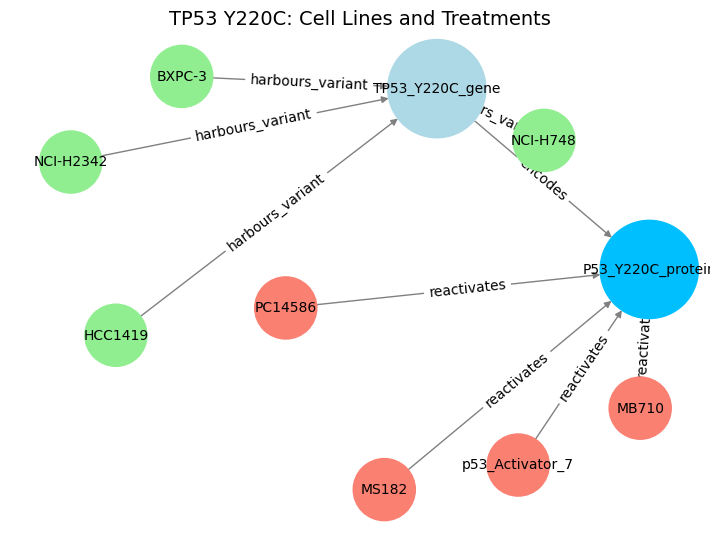

In [ ]:
# --- Build the graph ---
G = nx.DiGraph()

# Add mutation and protein nodes
G.add_node("TP53_Y220C_gene", label="TP53_Y220C_gene", color="lightblue", size=5000)
G.add_node("P53_Y220C_protein", label="P53_Y220C_protein", color="deepskyblue", size=5000)
G.add_edge("TP53_Y220C_gene", "P53_Y220C_protein", label="encodes")

# Add cell lines
for _, row in df_Y220C_Cell.iterrows():
    G.add_node(row["CellLine"], label=row["CellLine"], color="lightgreen", size=2000)
    G.add_edge(row["CellLine"], "TP53_Y220C_gene", label="harbours_variant")

# Add treatments
for _, row in df_Y220C_treatment.iterrows():
    G.add_node(row["treatment"], label=row["treatment"], color="salmon", size=2000)
    G.add_edge(row["treatment"], row["target"], label="reactivates")


# --- Step 3: Visualize ---
pos = nx.spring_layout(G, k=1.5, seed=42)
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_sizes = [G.nodes[n]['size'] for n in G.nodes]
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(7, 5))
nx.draw(G, pos,
        labels=labels,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        font_size=10,
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("TP53 Y220C: Cell Lines and Treatments", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
cell_dfs = [df_WT_Cell,df_R175H_Cell, df_R273H_Cell,  df_R273C_Cell, df_R248W_Cell, df_R248Q_Cell, df_Y220C_Cell]

# Concatenate all into one DataFrame
df_all_cells = pd.concat(cell_dfs, ignore_index=True)


In [ ]:
df_all_cells

,CellLine,CancerType,ATCC_label,P53Mutation
0,U-2_OS,bone,HTB-96,WildType
1,MDA-MB-361,breast,HTB-27,WildType
2,LS174T,colon,CL-188,WildType
3,SW48,colon,CCL-231,WildType
4,A549,lung,CRM-CCL-185,WildType
5,NCI-H1882,lung,None,WildType
6,SW1990,pancreas,CRL-2172,WildType
7,AGS,stomach,CRL-1739,WildType
8,AU565,breast,CRL-2351,P53_R175H
9,SK-BR-3,breast,HTB-30,P53_R175H


## Direct effectors of P53

###Cell cycle

p53-mediated cell cycle arrest can occur at both the G1(p21) and G2/M (GADD45 or 14-3-3σ)checkpoints, serving as critical barriers against uncontrolled proliferation. In this study, we focus on three direct downstream effectors of p53 to investigate whether co-treatment with chemical modulators and natural toxins can enhance cell cycle arrest and produce synergistic effects.

In [ ]:
# SPARQL query
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?drug ?label ?comment ?action ?target
WHERE {
  ?drug a :ChemicalModulator .

  OPTIONAL { ?drug rdfs:comment ?comment . }
  OPTIONAL { ?drug :hasCASNo ?label . }

  {
    ?drug :activates_protein :P21_wildtype_protein .
    BIND("activates_protein" AS ?action)
    BIND(:P21_wildtype_protein AS ?target)
  }
  UNION
  {
    ?drug :stabilizes_protein :P21_wildtype_protein .
    BIND("stabilizes_protein" AS ?action)
    BIND(:P21_wildtype_protein AS ?target)
  }
  UNION
  {
    ?drug :upregulates_transcription_of :CDKN1A_gene .
    BIND("upregulates_transcription_of" AS ?action)
    BIND(:P21_wildtype_protein AS ?target)
  }
  UNION
  {
    ?drug :stabilizes_protein :_14_3_3_sigma_WildType_protein .
    BIND("stabilizes_protein" AS ?action)
    BIND(:14-3-3_WildType_protein AS ?target)
  }
  UNION
  {
    ?drug :activates_protein :_14_3_3_sigma_WildType_protein .
    BIND("activates_protein" AS ?action)
    BIND(:14_3_3_WildType_protein AS ?target)
  }
  UNION
  {
    ?drug :activates_protein :GADD45α_WildType_protein .
    BIND("activates_protein" AS ?action)
    BIND(:GADD45α_WildType_protein AS ?target)
  }
  UNION
  {
    ?drug :stabilizes_protein :GADD45α_WildType_protein .
    BIND("stabilizes_protein" AS ?action)
    BIND(:GADD45α_WildType_protein AS ?target)
  }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    print(row)
    rows.append({
        "treatment": row.drug.split("/")[-1],
        "target": row.target.split("/")[-1],
        "action": row.action.split("/")[-1],
        "comment": row.comment,
        "label": row.label
    })

# Convert to DataFrame
df_cycle_treatment = pd.DataFrame(rows)

(rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/CD437'), rdflib.term.Literal('125316-60-1'), rdflib.term.Literal('https://doi.org/10.1093/nar/27.15.3111 increases mRNA level'), rdflib.term.Literal('activates_protein'), rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/GADD45α_WildType_protein'))
(rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/CP-31398'), rdflib.term.Literal('259199-65-0'), rdflib.term.Literal('10.4161/cbt.1.1.41'), rdflib.term.Literal('upregulates_transcription_of'), rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/P21_wildtype_protein'))
(rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/Fusicoccin'), None, rdflib.term.Literal('10.1593/tlo.12409 inhibits cancer invasion'), rdflib.term.Literal('stabilizes_protein'), rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutat

In [ ]:
df_cycle_treatment

,treatment,target,action,comment,label
0,CD437,GADD45α_WildType_protein,activates_protein,https://doi.org/10.1093/nar/27.15.3111 increas...,125316-60-1
1,CP-31398,P21_wildtype_protein,upregulates_transcription_of,10.4161/cbt.1.1.41,259199-65-0
2,Fusicoccin,14-3-3_WildType_protein,stabilizes_protein,10.1593/tlo.12409 inhibits cancer invasion,None
3,NSC59984,P21_wildtype_protein,upregulates_transcription_of,https://doi.org/10.1158/0008-5472.CAN-13-1079,803647-40-7
4,Neobractatin,GADD45α_WildType_protein,activates_protein,None,None
5,hygrolidin,P21_wildtype_protein,activates_protein,10.1016/s0006-291x(02)02416-6,83329-73-1


/tmp/ipython-input-150-4038639015.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


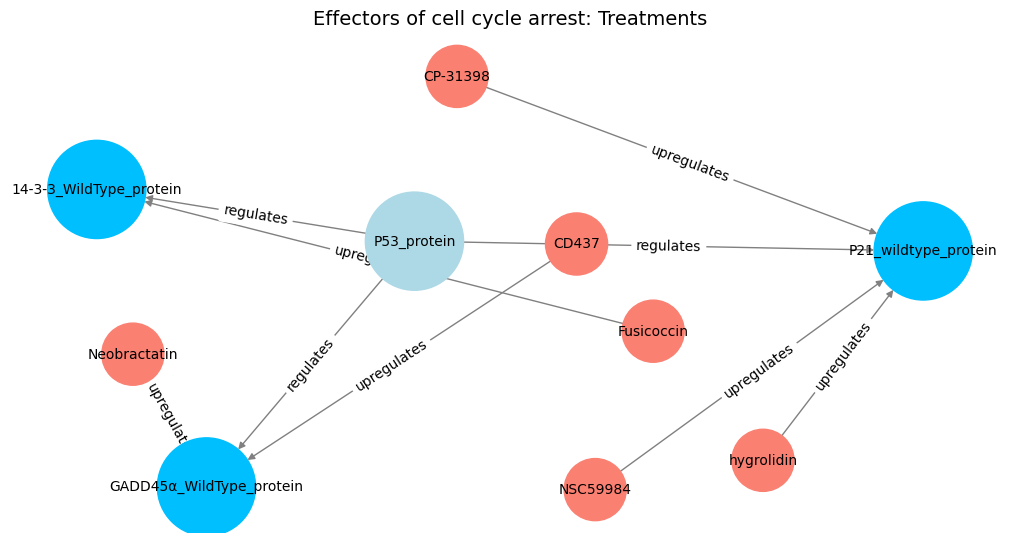

In [ ]:
# --- Build the graph ---
G = nx.DiGraph()

# Add mutation and protein nodes
G.add_node("P53_protein", label="P53_protein", color="lightblue", size=5000)
G.add_node("P21_wildtype_protein", label="P21_wildtype_protein", color="deepskyblue", size=5000)
G.add_edge("P53_protein", "P21_wildtype_protein", label="regulates")
G.add_node("GADD45α_WildType_protein", label="GADD45α_WildType_protein", color="deepskyblue", size=5000)
G.add_edge("P53_protein", "GADD45α_WildType_protein", label="regulates")
G.add_node("14-3-3_WildType_protein", label="14-3-3_WildType_protein", color="deepskyblue", size=5000)
G.add_edge("P53_protein", "14-3-3_WildType_protein", label="regulates")


# Add treatments
for _, row in df_cycle_treatment.iterrows():
    G.add_node(row["treatment"], label=row["treatment"], color="salmon", size=2000)
    G.add_edge(row["treatment"], row["target"], label="upregulates")


# --- Step 3: Visualize ---
pos = nx.spring_layout(G, k=1.5, seed=42)
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_sizes = [G.nodes[n]['size'] for n in G.nodes]
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(10, 5))
nx.draw(G, pos,
        labels=labels,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        font_size=10,
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Effectors of cell cycle arrest: Treatments", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

###Programmed cell death

Similarly, p53-mediated programmed cell death, or apoptosis, serves as a crucial barrier against uncontrolled cellular proliferation. In this study, we examine three direct downstream effectors of p53 to evaluate whether co-treatment with chemical modulators and natural toxins can enhance apoptotic responses and yield synergistic effects.

In [ ]:
# SPARQL query
query = """
PREFIX : <http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?drug ?label ?comment ?action ?target
WHERE {
  ?drug a :ChemicalModulator .

  OPTIONAL { ?drug rdfs:comment ?comment . }
  OPTIONAL { ?drug :hasCASNo ?label . }

  {
    ?drug :activates_protein :BAX_WildType_protein .
    BIND("activates_protein" AS ?action)
    BIND(:BAX_WildType_protein AS ?target)
  }
  UNION
  {
    ?drug :activates_protein :PUMA_WildType_protein .
    BIND("activates_protein" AS ?action)
    BIND(:PUMA_WildType_protein AS ?target)
  }
  UNION
  {
    ?drug :activates_protein :NOXA_WildType_protein .
    BIND("stabilizes_protein" AS ?action)
    BIND(:NOXA_WildType_protein AS ?target)
  }
}
"""

# Run query
results = g.query(query)

rows = []
for row in results:
    print(row)
    rows.append({
        "treatment": row.drug.split("/")[-1],
        "target": row.target.split("/")[-1],
        "action": row.action.split("/")[-1],
        "comment": row.comment,
        "label": row.label
    })

# Convert to DataFrame
df_apoptosis_treatment = pd.DataFrame(rows)

(rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/ABT-737'), None, rdflib.term.Literal('binds to Bcl-2 and freeing BAX 10.1016/j.ccr.2006.10.006'), rdflib.term.Literal('activates_protein'), rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/BAX_WildType_protein'))
(rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/BAM7'), None, rdflib.term.Literal('https://doi.org/10.1038/nchembio.995'), rdflib.term.Literal('activates_protein'), rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/BAX_WildType_protein'))
(rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/BTSA1'), rdflib.term.Literal('314761-14-3'), rdflib.term.Literal('10.1016/j.ccell.2017.09.001'), rdflib.term.Literal('activates_protein'), rdflib.term.URIRef('http://www.semanticweb.org/16380/ontologies/2025/4/p53_mutation/BAX_WildType_protein'))
(rdflib.term.URIRef('http

In [ ]:
df_apoptosis_treatment

,treatment,target,action,comment,label
0,ABT-737,BAX_WildType_protein,activates_protein,binds to Bcl-2 and freeing BAX 10.1016/j.ccr.2...,None
1,BAM7,BAX_WildType_protein,activates_protein,https://doi.org/10.1038/nchembio.995,None
2,BTSA1,BAX_WildType_protein,activates_protein,10.1016/j.ccell.2017.09.001,314761-14-3
3,Fluorizoline,NOXA_WildType_protein,stabilizes_protein,10.3324/haematol.2016.162958,None
4,Sabutoclax,PUMA_WildType_protein,activates_protein,10.1016/j.canlet.2018.02.036,1228108-65-3


/tmp/ipython-input-152-3615071342.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


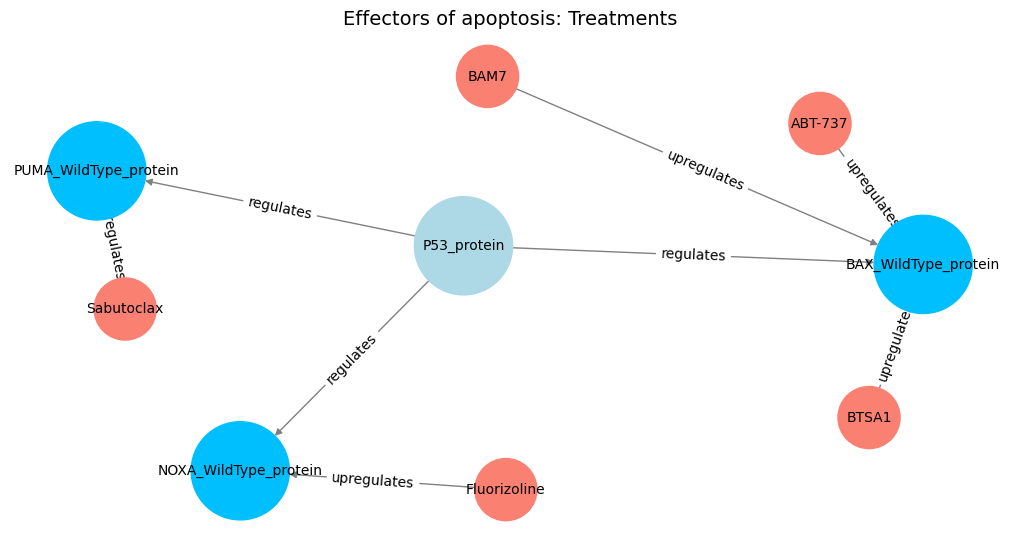

In [ ]:
# --- Build the graph ---
G = nx.DiGraph()

# Add mutation and protein nodes
G.add_node("P53_protein", label="P53_protein", color="lightblue", size=5000)
G.add_node("BAX_WildType_protein", label="BAX_WildType_protein", color="deepskyblue", size=5000)
G.add_edge("P53_protein", "BAX_WildType_protein", label="regulates")
G.add_node("NOXA_WildType_protein", label="NOXA_WildType_protein", color="deepskyblue", size=5000)
G.add_edge("P53_protein", "NOXA_WildType_protein", label="regulates")
G.add_node("PUMA_WildType_protein", label="PUMA_WildType_protein", color="deepskyblue", size=5000)
G.add_edge("P53_protein", "PUMA_WildType_protein", label="regulates")


# Add treatments
for _, row in df_apoptosis_treatment.iterrows():
    G.add_node(row["treatment"], label=row["treatment"], color="salmon", size=2000)
    G.add_edge(row["treatment"], row["target"], label="upregulates")


# --- Step 3: Visualize ---
pos = nx.spring_layout(G, k=1.5, seed=42)
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_sizes = [G.nodes[n]['size'] for n in G.nodes]
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(10, 5))
nx.draw(G, pos,
        labels=labels,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        font_size=10,
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Effectors of apoptosis: Treatments", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

Future work includes using this structured knowledge graph as input for machine reasoning (e.g., logical inference or drug combination ranking).